In [4]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import numpy as np
import tensorflow.keras.backend as kb
import ml_util
import time
# import model_util
from scipy import signal
import importlib


#trt stuff
from tensorflow.keras.mixed_precision import set_global_policy, Policy

mixed_precision_policy = Policy('mixed_float16')
set_global_policy(mixed_precision_policy)


In [5]:
#Experiment_options
importlib.reload(ml_util)
window_size = 80
# num_snapshots_in_sequence = 128
num_snapshots_in_sequence = 256

# use_smooth = False
use_smooth = False
do_filter = False
predict_future_by = 0 # num samples to predict into the future

use_side_flag = False
subjects_to_train_with = [1,2,3,4,5,6,7,8,9]

# b, a = signal.butter(Wn=0.1, N=1)

# sides = ['LEFT', 'RIGHT']
sides = ['LEFT']

trial_nums = 1+np.arange(11)
print('trials to train with: ', trial_nums, 'subjects to train with: ', subjects_to_train_with)

root_folder = "Exo_data_labelled"
# root_folder = "latest_dataset"

print(root_folder)
sequence_len = num_snapshots_in_sequence + window_size - 1
training_instances = np.empty(shape=[0,sequence_len, 10], dtype=np.float32)
b,a = signal.butter(Wn=0.1,N=2)
files_to_train_with = ml_util.get_files_to_use(root_folder, subjects_to_train_with, sides, trial_nums)
# print(files_to_train_with)

trials to train with:  [ 1  2  3  4  5  6  7  8  9 10 11] subjects to train with:  [1, 2, 3, 4, 5, 6, 7, 8, 9]
Exo_data_labelled


In [3]:
# import matplotlib.pyplot as plt
# import pandas as pd
# %matplotlib tk
# df = pd.read_csv('20230511_1144_S10_T01_LEFT.csv')
# # plt.plot(df['loop_time'], df['commanded_torque'])

# plt.plot(df['loop_time'], 100*df['TM_Stance_Phase'])

# # plt.plot(df['loop_time'], df['TM_Stance_Phase'])
# # plt.plot(df['loop_time'], df['TM_Is_Stance_Phase'])

# # plt.plot(df['loop_time'], df['Treadmill_Force_Z'])
# plt.plot(df['loop_time'], df['gyro_z'])
# # plt.plot(df['loop_time'], 120*df['did_heel_strike'])

# plt.show()

shape of x_train:  (3801, 335, 8) shape of y_gp_train:  (3801, 256) shape of y_ss_train:  (3801, 256) 
shape of x_valid:  (950, 335, 8) shape of y_gp_valid:  (950, 256) shape of y_ss_valid:  (950, 256)
<dtype: 'float32'>


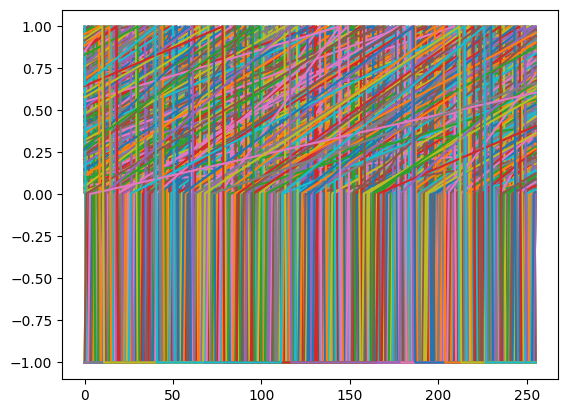

In [6]:
for myfile in files_to_train_with:
    data = ml_util.load_file(myfile)
    # ss_col = data[:,-2] #if using latest_dataset
    ss_col = data[:,-1] #if using exo_data_labeled

    ss_col[ss_col==0]=-1
    data[:,-1] = ss_col

    # print(myfile)
    num_rows, num_cols = data.shape
    # print(num_cols)
    num_rows_to_drop = num_rows % sequence_len

    data = data[0:-num_rows_to_drop]
    new_num_rows, num_cols = data.shape
    num_sequences = new_num_rows/sequence_len
    new_data_shape = (int(num_sequences), sequence_len, num_cols)
    new_instances = data.reshape(new_data_shape)
    # print("here")
    # print(new_instances.shape)
    training_instances = np.append(training_instances, new_instances, axis=0)
    # print(training_instances.shape)

    # Make 0 -> -1


shuffled_training_instances = tf.random.shuffle(training_instances) 
num_channels = 9 if use_side_flag else 8
x = shuffled_training_instances[:, :, :num_channels]
y_gp = shuffled_training_instances[:, window_size-1:,-1]
y_ss = shuffled_training_instances[:, window_size-1:,-2]



split_fraction = 0.8
split_num = int(np.rint(split_fraction*x.shape[0]))
x_train = x[:split_num,:,:]
x_train = tf.cast(x_train, tf.float32)
y_gp_train = y_gp[:split_num,:]
y_ss_train = y_ss[:split_num,:]

x_valid = x[split_num:,:,:]
y_gp_valid = y_gp[split_num:,:]
y_ss_valid = y_ss[split_num:,:]

print('shape of x_train: ', x_train.shape, 'shape of y_gp_train: ', y_gp_train.shape, 'shape of y_ss_train: ', y_ss_train.shape,
'\nshape of x_valid: ', x_valid.shape, 'shape of y_gp_valid: ', y_gp_valid.shape, 'shape of y_ss_valid: ', y_ss_valid.shape)
print(x_train.dtype)
plt.plot(np.transpose(y_gp_valid))
plt.show()

In [7]:
y_gp

<tf.Tensor: shape=(4751, 256), dtype=float64, numpy=
array([[ 0.35338346,  0.36090226,  0.36842105, ...,  0.67647059,
         0.68382353,  0.69117647],
       [ 0.31578947,  0.32236842,  0.32894737, ...,  0.54482759,
         0.55172414,  0.55862069],
       [ 0.38297872,  0.39007092,  0.39716312, ...,  0.65714286,
         0.66428571,  0.67142857],
       ...,
       [-1.        , -1.        , -1.        , ...,  0.65703971,
         0.66064982,  0.66425993],
       [ 0.93243243,  0.93918919,  0.94594595, ..., -1.        ,
        -1.        , -1.        ],
       [ 0.65217391,  0.66086957,  0.66956522, ..., -1.        ,
        -1.        , -1.        ]])>

In [8]:
print(x.shape)
print(y_gp.shape)
print(y_ss.shape)

(4751, 335, 8)
(4751, 256)
(4751, 256)


In [6]:
# # # Assuming you have the data stored in the variable 'data'
# # # You can extract the channel you want to plot

# # Create a plot
# import mpld3
# mpld3.enable_notebook()

# plt.figure(figsize=(15, 10))
# for channel_index in [3,4,5,9,10]:
#     selected_channel = data[:, channel_index]
#     plt.plot(range(len(selected_channel[0:5000])), selected_channel[0:5000])
#     # plt.plot(range(len(selected_channel_2[0:5000])), selected_channel_2[0:5000])
#     # plt.plot(range(len(selected_channel_3[0:5000])), selected_channel_3[0:5000])

# plt.xlabel('Sample Index')
# plt.ylabel('Channel Value')
# plt.title(f'Plot of Channel {channel_index}')
# plt.show()

In [9]:
def custom_loss(y_actual, y_pred):
    mask = kb.greater(y_actual, 0)
    mask = tf.cast(mask, tf.float32)
    custom_loss = tf.math.reduce_sum(
        kb.square(mask*(y_actual-y_pred)))/tf.math.reduce_sum(mask)
    return custom_loss

In [10]:
def construct_model_2023(window_size,
                         filter_sizes,
                         kernel_sizes,
                         dilations,
                         num_channels=8,
                         batch_norm_insertion_pts=[2],
                         gp_dense_sizes=[20, 10],
                         ss_dense_sizes=[20, 10],
                         do_fix_input_dim=False):
  if len(filter_sizes) != len(kernel_sizes)+1:
      raise ValueError(
          'Must provide one more filter size than kernel size--last kernel size is calculated')
  current_output_size = window_size  # Track for final conv layer

  #Use None in dim 0 to allow variable input length.
  #Use window_size to fix size--helpful for debugging dimensions
  if do_fix_input_dim:
    input_layer = tf.keras.layers.Input(
        shape=(window_size, num_channels), name='my_input_layer')
  else:
    input_layer = tf.keras.layers.Input(
        shape=(None, num_channels), name='my_input_layer')

  z = input_layer
  for layer_idx in range(len(kernel_sizes)):
      z = tf.keras.layers.Conv1D(filters=filter_sizes[layer_idx], kernel_size=kernel_sizes[layer_idx],
                                  dilation_rate=dilations[layer_idx], activation='relu')(z)
      if layer_idx in batch_norm_insertion_pts:
          z = tf.keras.layers.BatchNormalization()(z)
      current_output_size = current_output_size - \
          dilations[layer_idx]*kernel_sizes[layer_idx] + dilations[layer_idx]
  if current_output_size < 1:
      raise ValueError('layers shrink the cnn too much')
  else:
      print('adding final conv layer of kernel size: ', current_output_size)
      last_conv_layer = tf.keras.layers.Conv1D(
          filters=filter_sizes[-1], kernel_size=current_output_size, activation='relu')(z)

  # gait phase DNN
  z = last_conv_layer
  for num_neurons in gp_dense_sizes:
      z = tf.keras.layers.Dense(num_neurons, activation='relu')(z)
  output_gait_phase = tf.keras.layers.Dense(1, name='gait_phase_output')(z)
  output_gait_phase = tf.keras.layers.Activation('linear', dtype='float32')(output_gait_phase)  #trt change, comment this if not using


  z = last_conv_layer
  for num_neurons in ss_dense_sizes:
      z = tf.keras.layers.Dense(num_neurons, activation='relu')(z)
  output_stance_swing = tf.keras.layers.Dense(
      1, activation='sigmoid', name='stance_swing_output')(z)
  output_stance_swing = tf.keras.layers.Activation('sigmoid', dtype='float32')(output_stance_swing) #trt change, comment this if not using


  model = tf.keras.Model(inputs=[input_layer], outputs=[
      output_gait_phase, output_stance_swing])

  return model




In [11]:
# BUILD MODEL
importlib.reload(ml_util)

num_channels = 8
# window_size = 60
do_fix_input_dim=False

tf.keras.backend.clear_session()

model = construct_model_2023(window_size=window_size,
    filter_sizes=[30,30,30,30], kernel_sizes=[20,20, 20], dilations=[1,1,1], num_channels=8,
    batch_norm_insertion_pts=[0,1,2], gp_dense_sizes=[20,20,20], ss_dense_sizes=[20,20], do_fix_input_dim=do_fix_input_dim)

print(model.summary())
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=[ml_util.custom_loss, 'binary_crossentropy'], loss_weights=[0.95, 0.05], optimizer=optimizer)

adding final conv layer of kernel size:  23
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 my_input_layer (InputLayer)    [(None, None, 8)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, None, 30)     4830        ['my_input_layer[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, None, 30)    120         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv1d_1 (Conv1D)              (None, None, 30)  

In [12]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)
mc = tf.keras.callbacks.ModelCheckpoint('testmodel.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
history = model.fit(x=x_train, y=[y_gp_train, y_ss_train], 
    batch_size=32, epochs=30, validation_data=(x_valid,[y_gp_valid, y_ss_valid]), 
    callbacks=[es, mc], verbose=1)

Epoch 1/30
119/119 [==============================] - ETA: 0s - loss: 0.0484 - activation_loss: 0.0222 - activation_1_loss: 0.5475
Epoch 1: val_loss improved from inf to 0.04973, saving model to testmodel.h5
119/119 [==============================] - 352s 3s/step - loss: 0.0484 - activation_loss: 0.0222 - activation_1_loss: 0.5475 - val_loss: 0.0497 - val_activation_loss: 0.0259 - val_activation_1_loss: 0.5025
Epoch 2/30
119/119 [==============================] - ETA: 0s - loss: 0.0377 - activation_loss: 0.0148 - activation_1_loss: 0.4747
Epoch 2: val_loss improved from 0.04973 to 0.03447, saving model to testmodel.h5
119/119 [==============================] - 338s 3s/step - loss: 0.0377 - activation_loss: 0.0148 - activation_1_loss: 0.4747 - val_loss: 0.0345 - val_activation_loss: 0.0118 - val_activation_1_loss: 0.4662
Epoch 3/30
119/119 [==============================] - ETA: 0s - loss: 0.0356 - activation_loss: 0.0128 - activation_1_loss: 0.4684
Epoch 3: val_loss improved from 0.034

In [ ]:
model.save('1_9_both_trt_test.h5')

In [ ]:
# model = tf.keras.models.load_model('testmodel.h5', custom_objects={'custom_loss': custom_loss})

In [5]:
model = tf.keras.models.load_model('1_9_both.h5', custom_objects={'custom_loss': custom_loss})

In [6]:
model.summary()
print(model.metrics_names)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 my_input_layer (InputLayer)    [(None, None, 8)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, None, 30)     4830        ['my_input_layer[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, None, 30)    120         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv1d_1 (Conv1D)              (None, None, 30)     18030       ['batch_normalization[0][0]']

In [7]:
subjects_to_test_with = [10]
trial_nums = [2]
print('trials to test with: ', trial_nums, 'subjects to train with: ', subjects_to_test_with)
sides = ['LEFT']

root_folder = "Exo_data_labelled"
print(root_folder)

files_to_test_with = ml_util.get_files_to_use(root_folder, subjects_to_test_with, sides, trial_nums)
print(files_to_test_with)

trials to test with:  [2] subjects to train with:  [10]
Exo_data_labelled
['Exo_data_labelled\\S10\\20230511_1154_S10_T02_LEFT.csv']


In [10]:
training_instances = np.empty(shape=[0,sequence_len, 11], dtype=np.float32)
rmses = []
rmses_filt = []
gp_results = []
ss_results = []
all_stance_err = np.empty(1)
all_stance_gp_true = np.empty(1)

for myfile in files_to_test_with:
    data = ml_util.load_file(myfile)
   


    x_test = tf.expand_dims(data[:,:num_channels], axis=0)
    x_test=tf.cast(x_test, dtype = tf.float32)
    y_gp_test = data[window_size-1:,-1]
    y_ss_test = data[window_size-1:,-2]

    # y_gp_test = data[:,-1]
    # y_ss_test = data[:,-2]

    model_outputs = model.predict(x=x_test)    

    y_gp_predict, y_ss_predict = tf.squeeze(model_outputs)
    y_ss_predict_bool = tf.math.round(y_ss_predict)

    err = y_gp_predict-y_gp_test
    err = err[y_ss_test == True].numpy()
    y_gp_stance = y_gp_test[y_ss_test == True]

    all_stance_err = np.append(all_stance_err, err)
    all_stance_gp_true = np.append(all_stance_gp_true, y_gp_stance)
    rmse = np.sqrt(np.mean(np.square(err))) 

    y_gp_predict_filt = signal.lfilter(b,a,y_gp_predict.numpy())
    rmses_filt.append(np.sqrt(np.mean((y_gp_test-y_gp_predict_filt)**2)))

    rmses.append(rmse)

    y_gp_test_yo = tf.expand_dims(y_gp_test, axis = 0)
    y_ss_test_yo = tf.expand_dims(y_ss_test, axis = 0)
    results = model.evaluate(x=x_test, y=(y_gp_test_yo, y_ss_test_yo), verbose = 0)
    gp_results.append(results[1])

    # gp_results.append(np.sqrt(results[1]))
    ss_results.append(results[2])
    print(y_gp_test_yo.shape)
    # plt.plot(y_gp_test_yo[0,:])

    plt.figure()
    plt.plot(y_gp_test)
    plt.plot(y_gp_predict)
    plt.figure()
    plt.plot(y_ss_predict)
    plt.plot(y_ss_test)
    # plt.plot(0.001*x_test.numpy()[0,:,5])
    # plt.xlabel('Time Domain')
    # plt.ylabel('Stance Phase')

print('RSME_gp:', np.mean(gp_results), np.mean(rmses), 'filt rmse: ', np.mean(rmses_filt))
print('mean error_ss:', np.mean(ss_results))




1/1 [==============================] - 0s 47ms/step
(1, 56332)
RSME_gp: 0.0017412902088835835 0.042101 filt rmse:  0.3802574121334817
mean error_ss: 0.0661764144897461


In [ ]:
# import mpld3
# mpld3.enable_notebook()
import matplotlib.pyplot as plt
%matplotlib tk

y_gp_predict_temp = y_gp_predict.numpy()
# y_gp_predict_temp[y_ss_predict_bool==False] = None
# plt.figure(figsize=(15, 10))
plt.plot(y_gp_test)
# plt.plot(y_ss_test)
# plt.plot(y_gp_predict_temp)
plt.plot(0.001*x_test.numpy()[0,:,5])
plt.xlabel('Time Domain')
plt.ylabel('Stance Phase')

In [ ]:
print(x_test.numpy()[0,:,1])


In [ ]:
plt.figure()
plt.plot(y_ss_test)
plt.plot(y_ss_predict.numpy())

In [9]:
import matplotlib.pyplot as plt
%matplotlib tk

In [ ]:
window_size = 80
# num_snapshots_in_sequence = 128
num_snapshots_in_sequence = 256

In [8]:
window_size = 80
num_channels = 8
data = np.random.rand(window_size+5,num_channels)
x_test = tf.expand_dims(data[:,:num_channels], axis=0)
x_test=tf.cast(x_test, dtype = tf.float32)

model_outputs = model.predict(x_test)
print(model_outputs)

1/1 [==============================] - 1s 560ms/step
[array([[[0.04325192],
        [0.04389922],
        [0.04428335],
        [0.04461724],
        [0.04486643],
        [0.04497458]]], dtype=float32), array([[[0.08397057],
        [0.08270709],
        [0.082366  ],
        [0.08241905],
        [0.08203001],
        [0.08137424]]], dtype=float32)]
